# XGBoost model

In [140]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [141]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [142]:
df = pd.read_csv("dataset/preprocessed_train_PCA.csv")

In [143]:
df = df.drop(['NumberOfCustomers'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [144]:
df = df[df.IsOpen == 1]

In [145]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [146]:
df.shape

(433958, 44)

In [147]:
train = md.get_fake_train(df)

In [148]:
train.shape

(397047, 44)

In [149]:
test = md.get_fake_test(df)
test.shape

(36911, 44)

### Selecting predictive features 

In [150]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
#features.remove('Events_Thunderstorm')
#features.remove('Events_Fog')
features.remove('D_DayOfweek')
features.remove('Date')
print("features")

pprint(features)

features
['Unnamed: 0',
 'IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12']


In [151]:
features.remove('p11')
features.remove('p12')
features.remove('p7')
features.remove('p9')

features.remove('p8')
features.remove('p10')

In [152]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [153]:
#from xgboost.sklearn import XGBRegressor # wrapper
## XGB with sklearn wrapper
## the same parameters as for xgboost model
#params_sk = {'max_depth': 8, 
#            'n_estimators': 100, # the same as num_rounds in xgboost
#            'objective': 'reg:linear', 
#            'subsample': 1.0, 
#            'colsample_bytree': 0.3, 
#            'learning_rate': 0.1, 
#            'seed': 23}     
#
#skrg = XGBRegressor(**params_sk)
#
#skrg.fit(X_train[features], np.log(X_train["NumberOfSales"] + 1))

In [154]:
#import scipy.stats as st
#
#params_grid = {  
#    'learning_rate': st.uniform(0.001, 0.2),
#    'max_depth': list(range(6, 20, 2)),
#    'gamma': st.uniform(0, 40),
#    'reg_alpha': st.expon(0, 40)}
#
#search_sk = RandomizedSearchCV(skrg, params_grid, cv = 3, verbose=2) # 3 fold cross validation
#search_sk.fit(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#
## best parameters
#print(search_sk.best_params_); print(search_sk.best_score_)

### Hyperparameters tuning
The result was obtained using 0.3 of the train set (22 months) at random.
#### Result
{'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}
0.8171277539145538

In [155]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [156]:
X_train.shape

(377194, 44)

In [157]:
X_test.shape

(19853, 44)

In [158]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [159]:
#Using tuned params
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          "seed": 23,
          #"gamma": 14.5573974470,  #added as a test
          #"reg_alpha": 11.010959407512171
          }

#reg_alpha 
#reg_lambda
num_trees = 200 #400

In [160]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.33616	train-rmse:6.33473
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.0716	train-rmse:5.0706
[2]	test-rmse:4.06098	train-rmse:4.06022
[3]	test-rmse:3.2528	train-rmse:3.25236
[4]	test-rmse:2.60812	train-rmse:2.60795
[5]	test-rmse:2.09311	train-rmse:2.0931
[6]	test-rmse:1.68142	train-rmse:1.6818
[7]	test-rmse:1.3547	train-rmse:1.35543
[8]	test-rmse:1.09528	train-rmse:1.09636
[9]	test-rmse:0.882392	train-rmse:0.884237
[10]	test-rmse:0.719289	train-rmse:0.721615
[11]	test-rmse:0.590632	train-rmse:0.593681
[12]	test-rmse:0.489751	train-rmse:0.493349
[13]	test-rmse:0.412	train-rmse:0.416509
[14]	test-rmse:0.351329	train-rmse:0.356952
[15]	test-rmse:0.305666	train-rmse:0.312394
[16]	test-rmse:0.274083	train-rmse:0.281663
[17]	test-rmse:0.249737	train-rmse:0.258007
[18]	test-rmse:0.222472	train-rmse:0.231997
[19]	test-rmse:0.209773	train-rmse:0.219775
[20]	test-rm

### Plotting Trees

In [161]:
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['figure.figsize'] = [40.0,20.0]
#plt.rcParams['figure.dpi']=400
#plt.rcParams.update({'font.size': 30})

In [162]:
from xgboost import plot_tree
#plot_tree(gbm)


In [163]:
#xgb.to_graphviz(gbm, num_trees=0, rankdir='LR', **{'size':str(10)})

In [164]:
#xgb.to_graphviz(gbm, num_trees=1, rankdir='LR', **{'size':str(10)})

### Validating

In [165]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.10709803260120379


RMSE

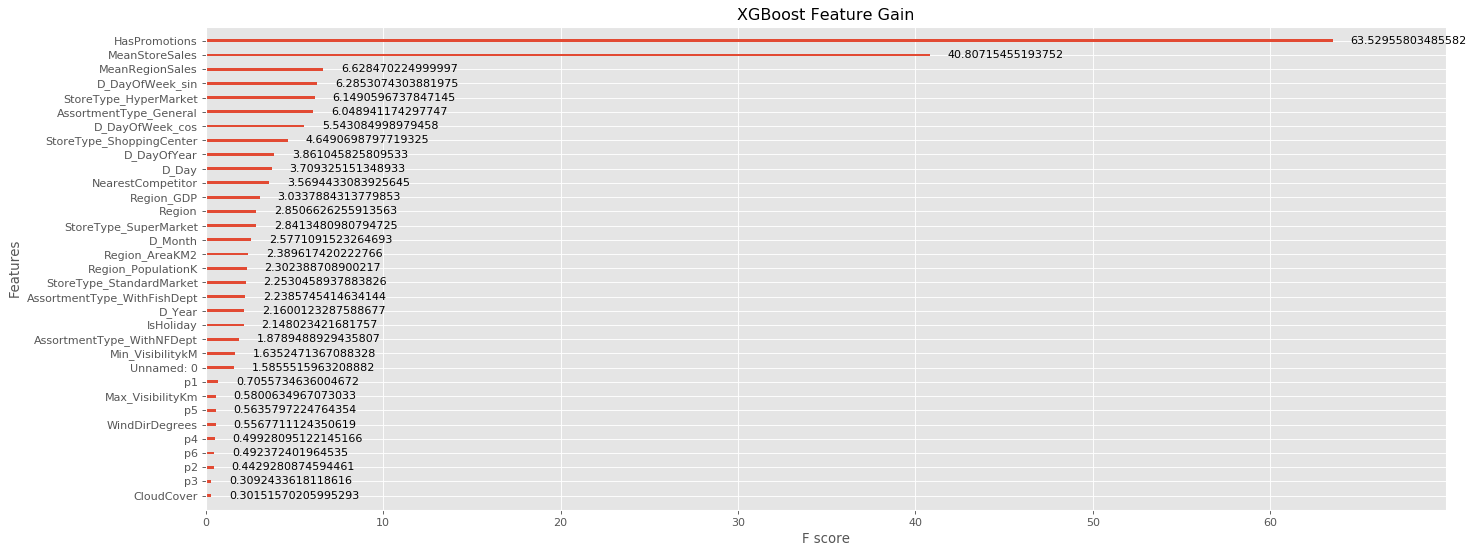

In [166]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

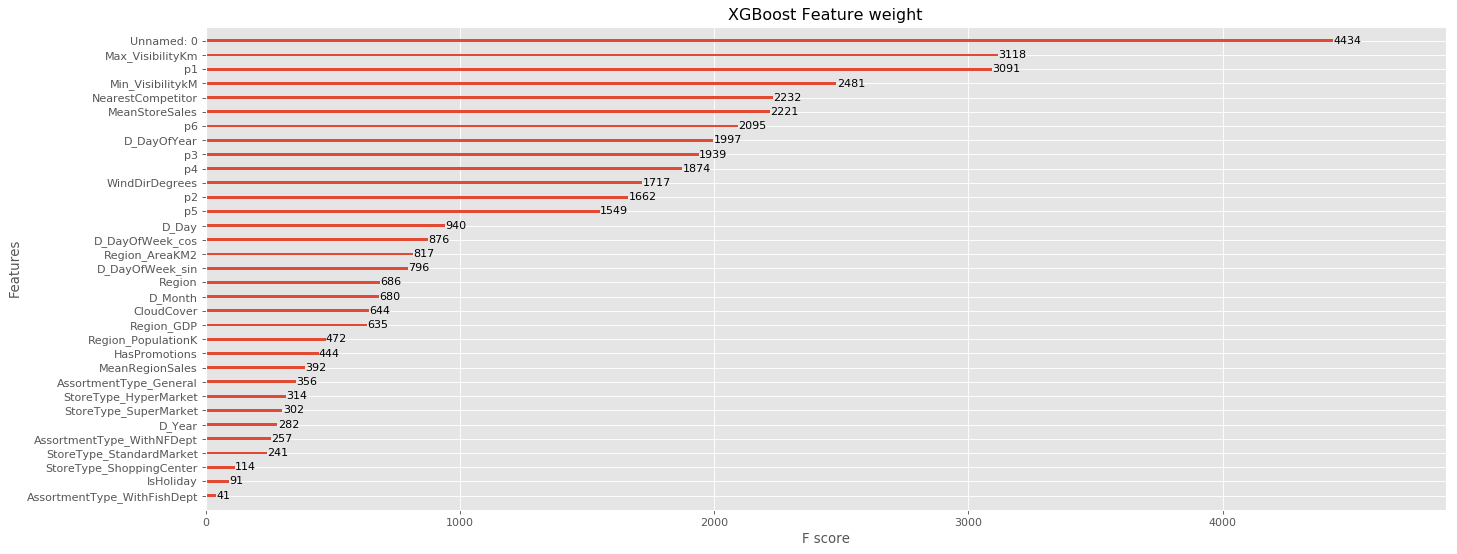

In [167]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

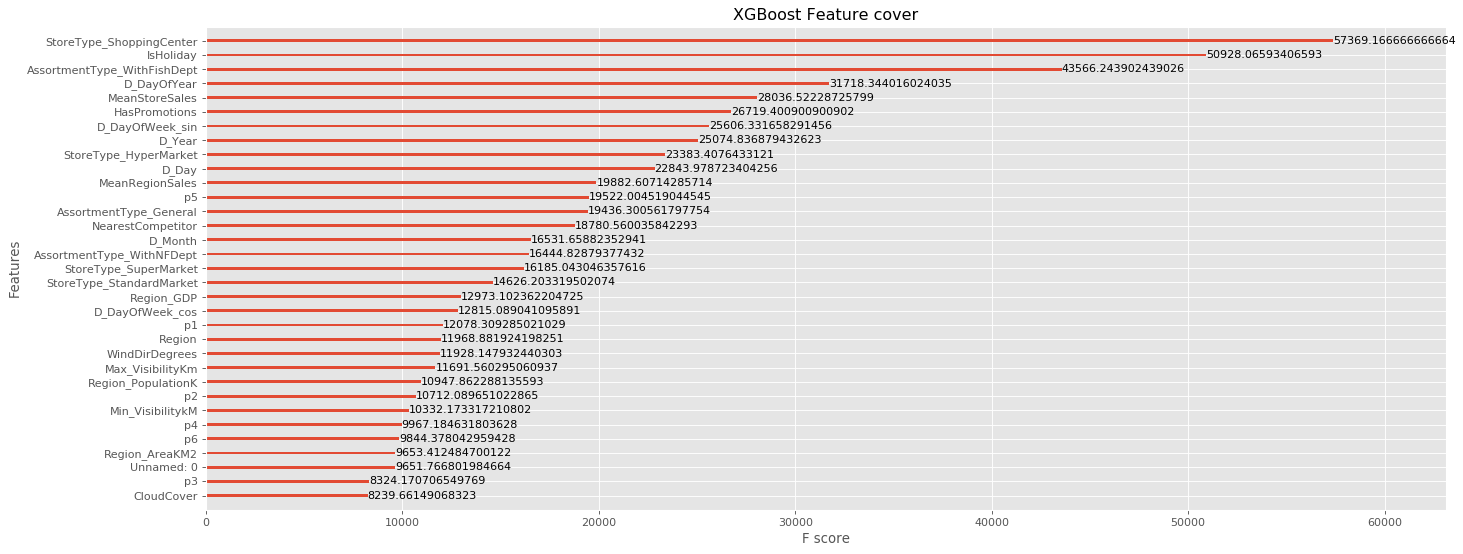

In [168]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [169]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [170]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [171]:
from BIP import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.04256526403253335


In [51]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [52]:
diff.head(15).T

670    -212.747070
671    2070.460938
672    -356.118652
674    -473.026855
675   -1303.062988
677   -1848.073242
678   -2160.660156
679   -2172.970703
680   -1432.466309
681    -185.285156
682    -684.897461
684      27.769531
685     744.705566
686   -1181.346680
687    -648.809082
dtype: float32

In [53]:
diff.mean()

-48.67221450805664

In [54]:
train_probs.shape

(36911,)

In [55]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [56]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [57]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [58]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.19567676584967392


In [59]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,4305.241211
14894,6795,6959.092773
14896,7035,7389.159668
14897,5437,6403.018066
14898,5725,6050.510254
14899,5143,6049.540527
14900,5589,6637.783203
14901,7520,6460.241211
14903,3927,5377.758301
14904,3682,4539.054688


In [60]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,4305.241211
14894,6795,6959.092773
14896,7035,7389.159668
14897,5437,6403.018066
14898,5725,6050.510254
14899,5143,6049.540527
14900,5589,6637.783203
14901,7520,6460.241211
14903,3927,5377.758301
14904,3682,4539.054688


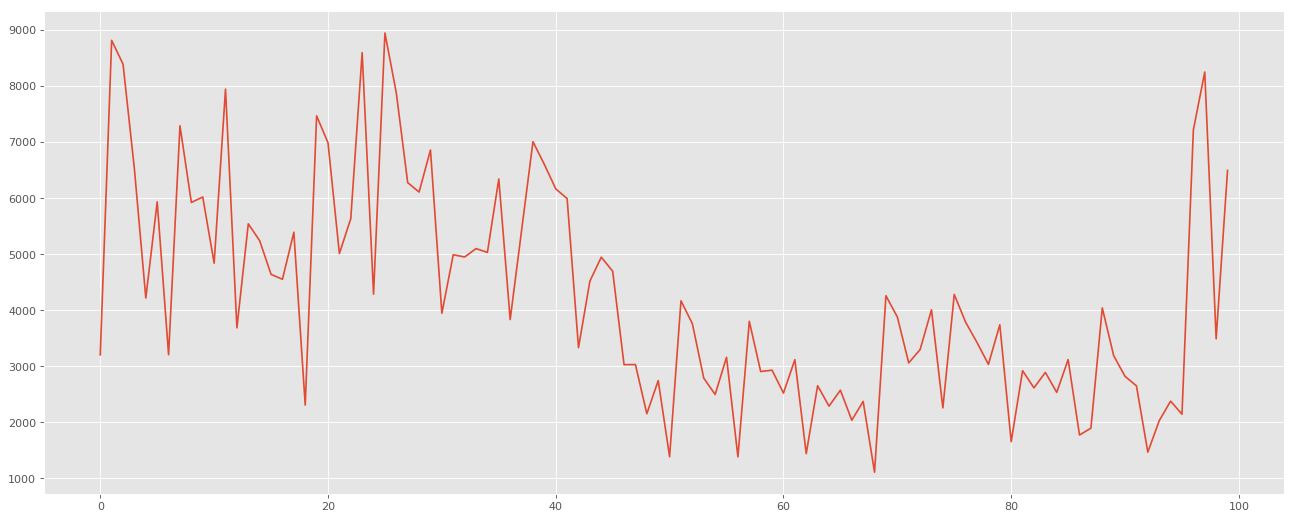

In [61]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

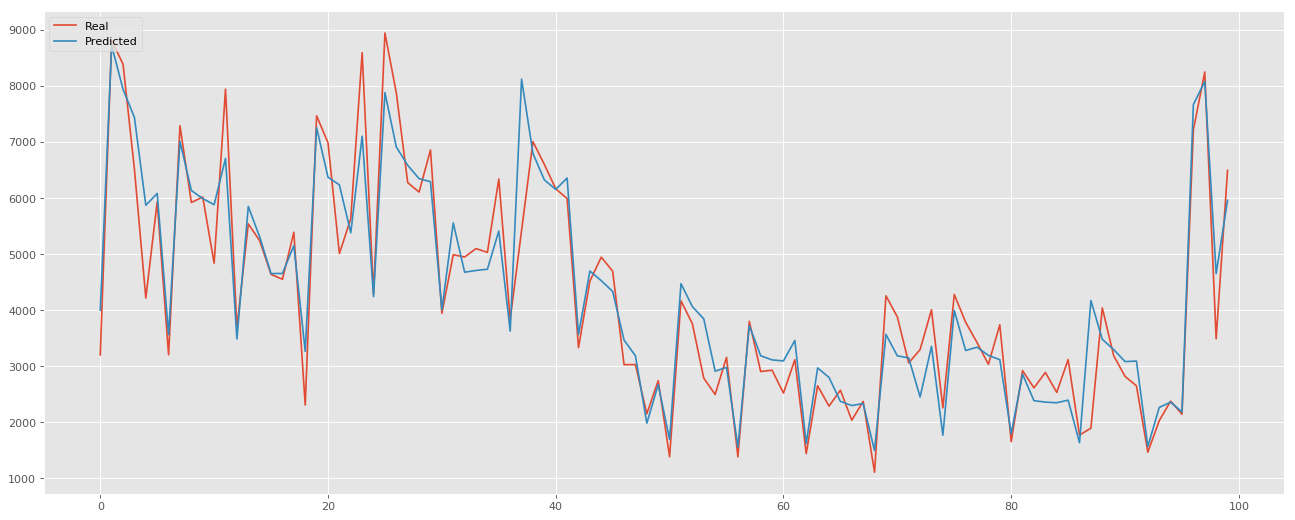

In [62]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

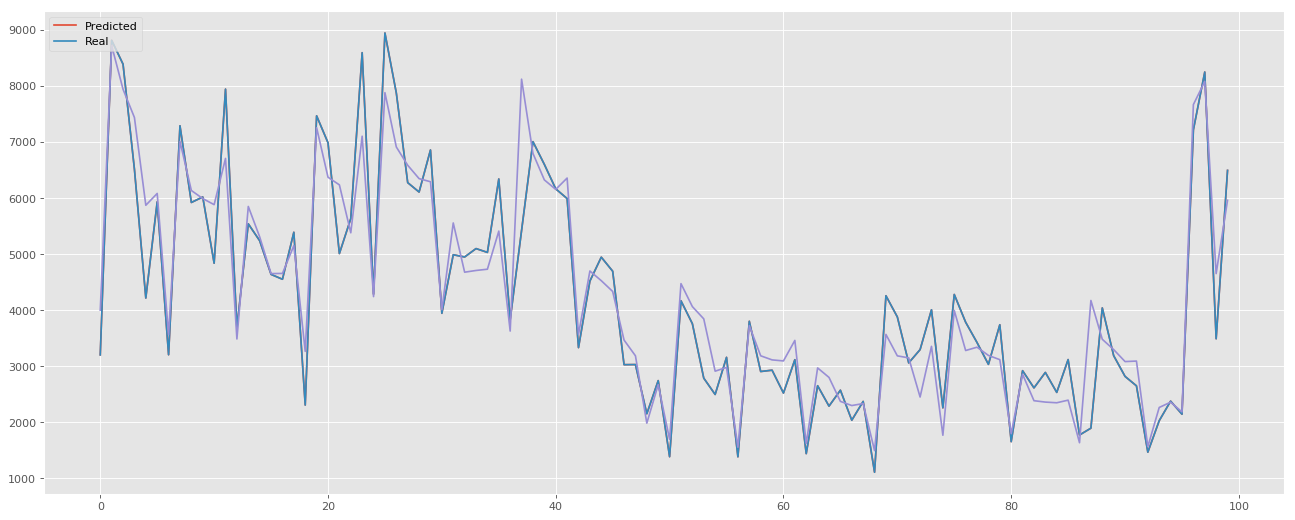

In [63]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [64]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y